In [1]:
import dataset
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.nn.functional as F
from torch.autograd import Variable
#import torchviz

np.random.seed(1)
torch.manual_seed(1)


In [2]:

def rotation_matrix_to_quaternion(M):
#   Note: M must have positive determinant.

    Q = torch.zeros(4)

    tr = M[0,0] + M[1,1] + M[2,2]
    if tr > 0.0: 
        s = 2.0 * math.sqrt(tr + 1.0)
        t = 1.0/s
        Q[0] = 0.25 * s
        Q[1] = (M[2,1] - M[1,2]) * t
        Q[2] = (M[0,2] - M[2,0]) * t
        Q[3] = (M[1,0] - M[0,1]) * t
    elif (M[0,0] > M[1,1]) and (M[0,0] > M[2,2]):
        s = 2.0 * math.sqrt(1.0 + M[0,0] - M[1,1] - M[2,2])
        t = 1.0/s
        Q[0] = (M[2,1] - M[1,2]) * t
        Q[1] = 0.25 * S
        Q[2] = (M[0,1] + M[1,0]) * t
        Q[3] = (M[0,2] + M[2,0]) * t
    elif M[1,1] > M[2,2]:
        s = 2.0 * math.sqrt(1.0 + M[1,1] - M[0,0] - M[2,2])
        t = 1.0/s
        Q[0] = (M[0,2] - M[2,0]) * t
        Q[1] = (M[0,1] + M[1,0]) * t
        Q[2] = 0.25 * s
        Q[3] = (M[1,2] + M[2,1]) * t
    else:
        s = 2.0 * math.sqrt(1.0 + M[2,2] - M[0,0] - M[1,1])
        t = 1.0/s
        Q[0] = (M[1,0] - M[0,1]) * t
        Q[1] = (M[0,2] + M[2,0]) * t
        Q[2] = (M[1,2] + M[2,1]) * t
        Q[3] = 0.25 * s
    
    return Q             

                 
def quaternion_to_rotation_matrix(Q):

    w = Q[0]
    x = Q[1]
    y = Q[2]
    z = Q[3]

    M = torch.zeros((3,3))
    
    M[0,0] = 1.0 - 2.0*(y*y + z*z)
    M[0,1] = 2.0*(x*y - w*z)
    M[0,2] = 2.0*(x*z + w*y)

    M[1,0] = 2.0*(x*y + w*z)
    M[1,1] = 1.0 - 2.0*(x*x + z*z)
    M[1,2] = 2.0*(y*z - w*x)

    M[2,0] = 2.0*(x*z - w*y)
    M[2,1] = 2.0*(y*z + w*x)
    M[2,2] = 1.0 - 2.0*(x*x + y*y)

    return M
                 
                 
def random_unit_quaternion():
                 
    Q = np.random.randn(4)
    norm = np.linalg.norm(Q)

    if norm > 1e-7:
        Q = Q/norm
    else:
        Q = np.array([1.0, 0.0, 0.0, 0.0])
        
    return torch.from_numpy(Q).float()
            
    

def random_rotation_matrix():
                 
    Q = random_unit_quaternion()        
    M = quaternion_to_rotation_matrix(Q)
                
    return M
                 

In [3]:
root = os.getcwd()

# choose dataset name from 'shapenetcorev2', 'shapenetpart', 'modelnet40' and 'modelnet10'
dataset_name = 'shapenetpart'

# choose split type from 'train', 'test', 'all', 'trainval' and 'val'
# only shapenetcorev2 and shapenetpart dataset support 'trainval' and 'val'
split = 'train'

d = dataset.Dataset(root=root, dataset_name=dataset_name, num_points=64, split=split, random_rotate=False)
print("datasize:", d.__len__())

item = 0
ps, lb, n, f = d[item]
print(ps.size(), ps.type(), lb.size(), lb.type(), n, f) 


datasize: 12137
torch.Size([64, 3]) torch.FloatTensor torch.Size([1]) torch.LongTensor airplane 02691156/points/d4d61a35e8b568fb7f1f82f6fc8747b8.pts


In [4]:
torch.save(ps, 'tensor.pt')

In [5]:
ps = torch.load('tensor.pt')
ps

tensor([[-7.3473e-01,  3.0682e-02,  3.1320e-02],
        [ 9.9903e-01, -4.0451e-02, -1.7362e-02],
        [-1.6597e-01,  1.7705e-02, -7.6738e-01],
        [ 1.3739e-01, -1.0413e-01,  3.2422e-01],
        [ 3.3625e-01, -4.5667e-02, -3.2143e-01],
        [-2.3002e-01,  1.6017e-02,  7.5248e-01],
        [-1.9326e-01,  2.3954e-02, -8.4011e-02],
        [ 5.4885e-01,  3.9149e-02,  8.1237e-02],
        [ 1.8642e-01,  9.9346e-02, -7.4597e-03],
        [-3.7332e-02, -1.1524e-02, -4.1972e-01],
        [-8.9101e-01,  3.5984e-01, -1.5229e-04],
        [-8.8131e-01,  1.0156e-01, -2.9089e-01],
        [-1.4384e-01, -9.5588e-03,  4.5041e-01],
        [-8.6798e-01,  1.0219e-01,  2.9869e-01],
        [-4.4342e-01,  2.7936e-02,  7.5441e-02],
        [-1.0103e-01, -3.0448e-02,  1.7815e-01],
        [ 7.5335e-01,  2.4912e-02, -8.3885e-02],
        [ 5.9575e-03, -1.3799e-01, -1.9448e-01],
        [ 3.4890e-01, -6.9605e-02, -1.1350e-03],
        [ 3.8085e-02, -6.9731e-02,  1.1061e-02],
        [ 3.3703e-01

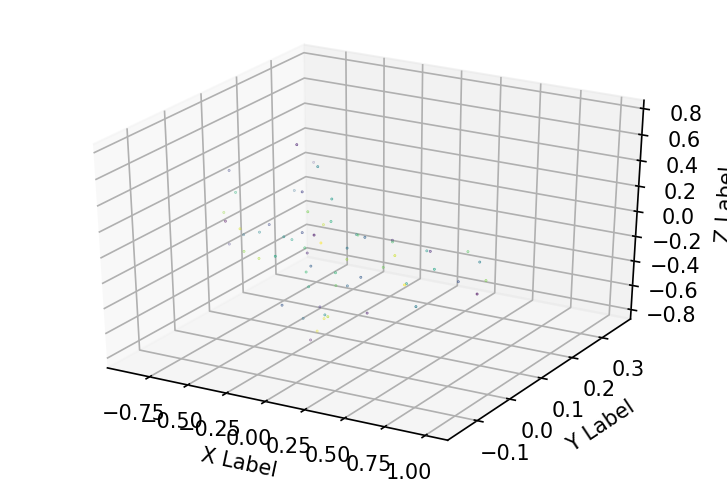

In [6]:
def randrange(n, vmin, vmax):
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, projection='3d')

#M = torch.from_numpy( random_rotation_matrix() ).float()
#ps = torch.mm(ps, M)

xs = ps[:,0]
ys = ps[:,1]
zs = ps[:,2]
cs = np.arange(ps.size()[0])
ax.scatter(xs, ys, zs, s=0.1, c=cs, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [7]:
class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

#         self.conv1 = torch.nn.Conv1d(3, 64, 1)
#         self.conv2 = torch.nn.Conv1d(64, 128, 1)
#         self.conv3 = torch.nn.Conv1d(128, 512, 1)
#         self.fc1 = nn.Linear(512, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, 4)
#         self.relu = nn.ReLU()

#         self.bn1 = nn.BatchNorm1d(64, track_running_stats=False)
#         self.bn2 = nn.BatchNorm1d(128, track_running_stats=False)
#         self.bn3 = nn.BatchNorm1d(512, track_running_stats=False)
#         self.bn4 = nn.BatchNorm1d(256, track_running_stats=False)
#         self.bn5 = nn.BatchNorm1d(128, track_running_stats=False)


    def forward(self, x):
        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
#         x = x.view(-1, 512)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

#         a = torch.from_numpy(np.array([1,0,0,0]).astype(np.float32))        
#         b = a.view(1,4).repeat(batchsize,1)
#         b.requires_grad = True
#         iden = Parameter(b)
#        iden = Variable(torch.from_numpy(np.array([1,0,0,0]).astype(np.float32))).view(1,4).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
#        x = x + iden
        x = x.view(-1, 4)
        return x


In [8]:
def training_loop(
    n_epochs, optimizer, model, loss_fn, train_loader, val_loader, device, verbosity=None):

    for epoch in range(0, n_epochs):
        total_loss_train = 0.0
        n_batches_train = 0
        for x_train, y_train in train_loader:
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            model.train()
            yhat_train = model(x_train)
            loss_train = loss_fn(y_train, yhat_train)
            total_loss_train += float(loss_train)
            n_batches_train += 1
#             print(y_train)
#             print(yhat_train)
#             print(loss_train)
#             print(n_batches_train)
            loss_train.backward()
            optimizer.step()
            optimizer.zero_grad()
             
        total_loss_val = 0.0
        n_batches_val = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                model.eval()
                yhat_val = model(x_val)
                loss_val = loss_fn(y_val, yhat_val)
                total_loss_val += float(loss_val)
                n_batches_val += 1
#                 print(n_batches_val)

                
        if verbosity is not None and epoch % verbosity == 0:
            total_loss_train = total_loss_train/max(1,n_batches_train)
            total_loss_val = total_loss_val/max(1,n_batches_val)
            print('Epoch {}, Training loss {}, Validation loss {}'.format(
                epoch, total_loss_train, total_loss_val))
            
        

In [9]:
size_batch = 1000
x_tensor = torch.zeros((size_batch, 3, ps.shape[0]))
y_tensor = torch.zeros((size_batch, 4))

In [10]:
Q = torch.zeros(4)
Q[0] = 1.0

for i in range(0,x_tensor.shape[0]):
    M = quaternion_to_rotation_matrix(Q)
    x_tensor[i] = torch.mm(ps, M).reshape(ps.shape[1], ps.shape[0])
    y_tensor[i] = Q
    Q = random_unit_quaternion()
    

In [11]:
size_val = size_batch//5
size_train = size_batch - size_val

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [size_train, size_val])

train_loader = DataLoader(dataset=train_dataset, batch_size=min(16,size_train))
val_loader = DataLoader(dataset=val_dataset, batch_size=min(16,size_val))


# size_train = size_batch
# dataset = TensorDataset(x_tensor, y_tensor)
# train_dataset = dataset
# train_loader = DataLoader(dataset=train_dataset, batch_size=size_train)
# val_loader = None


In [12]:
def QuatRotLoss(y, yhat):
#      loss = torch.mean( torch.min((y-yhat)**2, (y+yhat)**2) )
    loss = torch.mean( torch.min( ((y-yhat)**2).sum(dim=1), ((y+yhat)**2).sum(dim=1) ) )
#     loss = torch.mean( ((y-yhat)**2).sum(dim=1) )
    return loss

#model = SubclassFunctionalModel()
model = STN3d()
#optimizer = optim.SGD(model.parameters(), lr=1e-2)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# loss_fn = nn.MSELoss(reduction='mean')
loss_fn = QuatRotLoss
model, optimizer, loss_fn



(STN3d(
   (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
   (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
   (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
   (fc1): Linear(in_features=1024, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=256, bias=True)
   (fc3): Linear(in_features=256, out_features=4, bias=True)
   (relu): ReLU()
   (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     weight_decay: 1e-05
 ),
 <function __main_

In [45]:
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-5)

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
training_loop(
    40, optimizer, model, loss_fn, train_loader, val_loader, device, 1)

Epoch 0, Training loss 0.0028344170248601587, Validation loss 0.19724124670028687
Epoch 1, Training loss 0.0027945951535366474, Validation loss 0.19724256545305252
Epoch 2, Training loss 0.0027767667663283644, Validation loss 0.19725008595448273
Epoch 3, Training loss 0.002760094072436914, Validation loss 0.19724156363652304
Epoch 4, Training loss 0.0027440863370429723, Validation loss 0.19724667072296143
Epoch 5, Training loss 0.0027287229377543553, Validation loss 0.19724843020622546
Epoch 6, Training loss 0.0027135824924334885, Validation loss 0.19724757396257842
Epoch 7, Training loss 0.0026990589522756635, Validation loss 0.1972686883348685
Epoch 8, Training loss 0.002684496964211576, Validation loss 0.19724927785304877
Epoch 9, Training loss 0.0026704168610740455, Validation loss 0.19726266654638144
Epoch 10, Training loss 0.0026562803762499245, Validation loss 0.1972755308334644
Epoch 11, Training loss 0.0026424497278640046, Validation loss 0.19724983607347196
Epoch 12, Training

In [48]:
model.eval()
model(x_tensor[0].unsqueeze(0)).squeeze_()

tensor([ 0.9821, -0.0542,  0.0892,  0.0708], grad_fn=<SqueezeBackward2>)

In [183]:
with torch.no_grad():
    model.eval()
    M = model(x_tensor)
    print(y_tensor)
    print(M)
    print(float(loss_fn(y_tensor,M)))

tensor([[[ 1.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.9078, -0.4193,  0.0120],
         [-0.3835, -0.8412, -0.3812],
         [ 0.1699,  0.3415, -0.9244]],

        [[-0.2159,  0.4005, -0.8905],
         [-0.6102, -0.7673, -0.1972],
         [-0.7623,  0.5008,  0.4100]],

        [[ 0.3078,  0.5536, -0.7739],
         [-0.9251,  0.3641, -0.1074],
         [ 0.2223,  0.7490,  0.6242]],

        [[ 0.0971,  0.7201, -0.6870],
         [-0.9548,  0.2623,  0.1401],
         [ 0.2811,  0.6423,  0.7130]],

        [[ 0.0512, -0.5604, -0.8266],
         [ 0.5337, -0.6842,  0.4969],
         [-0.8441, -0.4667,  0.2640]],

        [[ 0.3076, -0.9462, -0.1000],
         [ 0.6709,  0.2902, -0.6824],
         [ 0.6747,  0.1428,  0.7241]],

        [[-0.2763, -0.9511,  0.1383],
         [-0.2805,  0.2175,  0.9349],
         [-0.9192,  0.2195, -0.3269]],

        [[ 0.4916, -0.1325,  0.8607],
         [ 0.5874,  0.7801, -0.215

In [53]:
with torch.no_grad():
    k = 100
    model.eval()
    Q = model(x_tensor[k].unsqueeze(0)).squeeze_()
    print(y_tensor[k])
    print(Q)
#     print(float(loss_fn(y_tensor[k],Q)))

tensor([ 0.9410,  0.3112, -0.0350, -0.1280])
tensor([ 0.9341,  0.2438, -0.0030, -0.0829])


In [93]:
y_tensor

tensor([[[ 1.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  1.0000]],

        [[ 0.3562,  0.9300, -0.0907],
         [-0.6391,  0.3133,  0.7024],
         [ 0.6817, -0.1922,  0.7060]],

        [[ 0.2505, -0.6943,  0.6747],
         [-0.9668, -0.2154,  0.1373],
         [ 0.0500, -0.6867, -0.7253]],

        [[-0.9499,  0.0894,  0.2995],
         [-0.3122, -0.3157, -0.8960],
         [ 0.0144, -0.9446,  0.3278]],

        [[-0.8169, -0.5753,  0.0414],
         [-0.0588,  0.0117, -0.9982],
         [ 0.5738, -0.8179, -0.0434]]])

In [105]:
A = torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]])
# A*A
(A*A).sum(dim=1)
# B = A*A
# B, B.sum(axis=1)
# float(A.dot(A))
# torch.abs(torch.tensor([-1,2,3]))
# C = (1.0 - (A*-A).sum(axis=1).abs())
# torch.max(C, torch.tensor([1.0,2.0]))
# torch.max(torch.tensor([-1,3]), torch.tensor([1,2]))

tensor([14., 77.])

In [59]:
with torch.no_grad():
    Q = random_unit_quaternion()
    M = quaternion_to_rotation_matrix(Q)
    xt = torch.mm(ps, M).reshape(ps.shape[1], ps.shape[0])
    yt = Q
    model.eval()
    yhat = model(xt.unsqueeze(0)).squeeze_()   
    print(yt)
    print(yhat)


tensor([-0.4129,  0.5611,  0.7154,  0.0534])
tensor([ 0.5664, -0.6701, -0.8286, -0.2011])
